In [13]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Lambda
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow_addons as tfa

from other_models.attention.attentive_pooling import AttentionWithContext

import numpy as np
import math
import matplotlib.pyplot as plt
import time


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

from data.pamap2.pamap2 import create_pamap2

In [14]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"

In [15]:
def window_warp(x, window_ratio=0.1, scales=[0.5, 2.]):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    warp_scales = np.random.choice(scales, x.shape[0])
    warp_size = np.ceil(window_ratio*x.shape[1]).astype(int)
    window_steps = np.arange(warp_size)
        
    window_starts = np.random.randint(low=1, high=x.shape[1]-warp_size-1, size=(x.shape[0])).astype(int)
    window_ends = (window_starts + warp_size).astype(int)
            
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            start_seg = pat[:window_starts[i],dim]
            window_seg = np.interp(np.linspace(0, warp_size-1, num=int(warp_size*warp_scales[i])), window_steps, pat[window_starts[i]:window_ends[i],dim])
            end_seg = pat[window_ends[i]:,dim]
            warped = np.concatenate((start_seg, window_seg, end_seg))                
            ret[i,:,dim] = np.interp(np.arange(x.shape[1]), np.linspace(0, x.shape[1]-1., num=warped.size), warped).T
    return ret

class Dataloader(Sequence):

    def __init__(self, x_set, y_set, batch_size, shuffle=False, finetuning=False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.finetuning = finetuning
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]
        batch_x, batch_y = np.array(batch_x), np.array(batch_y)

        if not self.finetuning:
            batch_x = window_warp(batch_x)

        return batch_x, batch_y

    # epoch이 끝날때마다 실행
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [16]:
secs = time.time()
tm = time.localtime(secs)

time_string = time.strftime('%Y%m%d%I%M%S', tm)
time_int = int(time_string) % (2**32 - 1)
time_string = str(time_int)
print('random_state : ' , time_int)

random_state :  4216976358


In [17]:
def CNN_Set(input_shape, kernel_size, name="Set"):
    
    inputs = tf.keras.layers.Input(input_shape)
    conv1 = tf.keras.layers.Conv1D(64, kernel_size=kernel_size, activation="relu")
    conv2 = tf.keras.layers.Conv1D(32, kernel_size=kernel_size, activation="relu")
    dropout = tf.keras.layers.Dropout(0.5)
    maxpooling = tf.keras.layers.MaxPool1D(pool_size=2)
    flatten = tf.keras.layers.Flatten()
    
    x = tf.keras.layers.TimeDistributed(conv1)(inputs)
    x = tf.keras.layers.TimeDistributed(conv2)(x)
    x = tf.keras.layers.TimeDistributed(dropout)(x)
    x = tf.keras.layers.TimeDistributed(maxpooling)(x)
    x = tf.keras.layers.TimeDistributed(flatten)(x)
    
    model = tf.keras.models.Model(inputs, x, name=name)
    return model

def Encoder(input_shape, name="encoder"):
    
    inputs = tf.keras.layers.Input(input_shape)
    branch_1 = CNN_Set(input_shape, kernel_size=3, name="branch_1")
    branch_2 = CNN_Set(input_shape, kernel_size=7, name="branch_2")
    branch_3 = CNN_Set(input_shape, kernel_size=11, name="branch_3")

    one = branch_1(inputs)
    two = branch_2(inputs)
    three = branch_3(inputs)
    concat = tf.keras.layers.Concatenate()([one, two, three])
    
    model = tf.keras.models.Model(inputs, concat, name=name)
    return model

def Balancing_Contrastive(input_shape, contrastive_outputs, n_outputs):
    inputs = tf.keras.layers.Input(input_shape)
    reshaped_inputs = tf.keras.layers.Reshape((4, 25, 18))(inputs)
    encoded = Encoder((4, 25, 18))(reshaped_inputs)
    
    ### classifier
    x = tf.keras.layers.Dropout(0.5)(encoded)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
    x =  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False))(x)
    x = tf.keras.layers.Dense(128)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    classified = tf.keras.layers.Dense(n_outputs, activation="softmax", name="classified")(x)
    
    ### contrastive
    x = tf.keras.layers.GlobalAveragePooling1D()(encoded)
    x = tf.keras.layers.LayerNormalization()(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    contrastive = tf.keras.layers.Dense(contrastive_outputs, activation="relu", name="contrastive")(x)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=[classified, contrastive], name="Balancing")     
    return model

In [18]:
def create_dataset(name, data_type="frequency_100"):
    print("creating dataset")
    if name == "pamap2":
        x_train, y_train = create_pamap2(data=data_type)

        # 80%, 10%, 10% respectively in train, val, test dataset
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=time_int, stratify=y_train)
        x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=time_int, stratify=y_test)
        print("x_train.shape : ", x_train.shape, "y_train.shape: ", y_train.shape)
        print("x_val.shape   : ", x_val.shape,    "y_val.shape: ", y_val.shape)
        print("x_test.shape  : ", x_test.shape,   "y_test.shape: ", y_test.shape)

        return x_train, y_train, x_val, y_val, x_test, y_test

In [19]:
batch = 32
epcohs = 100
learning_rate = 0.001

In [20]:
class SampleContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, batch, lam=0.0001, beta=0.5, margin=1.2, name=None):
        super(SampleContrastiveLoss, self).__init__(name=name)
        self.batch = batch
        self.lam = lam
        self.beta = beta
        self.margin = margin
        
        self.tril = tf.cast(tf.linalg.band_part(tf.ones(shape=(batch, batch)), -1, 0) == 1, tf.bool)
        # self.tril = tf.cast(tf.linalg.band_part(tf.ones(shape=(batch, batch)), -1, 0) == 1, tf.int32)
        self.crossentropy = tf.keras.losses.SparseCategoricalCrossentropy()
        
    def __call__(self, labels, feature_vectors, sample_weight=None):
        print(labels.shape, feature_vectors.shape)
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        r1 = tf.matmul(feature_vectors_normalized, tf.transpose(feature_vectors_normalized))
        r2 = tf.abs(tf.subtract(tf.expand_dims(labels, axis=1), tf.expand_dims(labels, axis=0)))
        r2 = tf.experimental.numpy.squeeze(r2, axis=-1)
        
        mask1 = tf.where(self.tril, tf.ones(shape=(self.batch, self.batch)), tf.cast(r2, tf.float32)) == 0
        mask2 = tf.where(self.tril, tf.zeros(shape=(self.batch, self.batch)), tf.cast(r2, tf.float32)) > 0
        
        sample_loss = self.lam * tf.math.reduce_sum(r1[mask1]) + self.beta * tf.nn.relu(tf.math.reduce_sum(self.margin - r1[mask2]))
        sample_loss = sample_loss / batch
        return sample_loss

class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

# Frequency 100Hz Testing

In [21]:
dataset_name = "pamap2"  
x_train, y_train, x_val, y_val, x_test, y_test = create_dataset(name=dataset_name, data_type="nooverlap")

## tensorflow에서 labels의 batch를 실시간으로 받을 수가 없고, 계속 None으로 계산됩니다.
## 이를 해결하기 위하여 pyotorch의 drop_last과 같이 batch가 항상 32개로 받도록 조정합니다.
# x_train = x_train[x_train.shape[0]%batch:]
# y_train = y_train[y_train.shape[0]%batch:]
# x_val = x_val[x_val.shape[0]%batch:]
# y_val = y_val[y_val.shape[0]%batch:]
# x_test = x_test[x_test.shape[0]%batch:]
# y_test = y_test[y_test.shape[0]%batch:]

# contrastive_y_train = np.argmax(frequency_100_y_train, axis=1)
# contrastive_y_val = np.argmax(frequency_100_y_val, axis=1)
# contrastive_y_test = np.argmax(frequency_100_y_test, axis=1)

print("contrastive_y_train shape : ", y_train.shape)
print("contrastive_y_val shape : ", y_val.shape)
print("contrastive_y_test shape : ", y_test.shape)

creating dataset
/home/tolom/20220621/contrastive_frequency
x_train.shape :  (15502, 100, 18) y_train.shape:  (15502,)
x_val.shape   :  (1938, 100, 18) y_val.shape:  (1938,)
x_test.shape  :  (1938, 100, 18) y_test.shape:  (1938,)
contrastive_y_train shape :  (15502,)
contrastive_y_val shape :  (1938,)
contrastive_y_test shape :  (1938,)


In [22]:
train_loader = Dataloader(x_train, y_train, 64, shuffle=True, finetuning=False)
valid_loader = Dataloader(x_val, y_val, 64, finetuning=False)
test_loader = Dataloader(x_test, y_test, 64, finetuning=False)

In [23]:
filepath = "result/frequency_" + dataset_name + "_" + time_string + ".h5"
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_classified_loss', factor=0.2, patience=5, min_lr=0.0001)
checkpoint = ModelCheckpoint(filepath, verbose = 0, monitor="val_classified_loss", mode="min", save_best_only=True, save_weights_only = True)

print("[Prtraninig Encoder with Supervised Contrastive Loss]")
model = Balancing_Contrastive(x_train.shape[1:], 64, len(np.unique(y_train)))
model.summary()

model.compile(loss=["sparse_categorical_crossentropy", SupervisedContrastiveLoss()], loss_weights=[1, 0.01], optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])
# history = model.fit(frequency_100_x_train, [frequency_100_y_train, contrastive_y_train], validation_data=(frequency_100_x_val, [frequency_100_y_val, contrastive_y_val]), batch_size=32, epochs=50, verbose=1, callbacks=[reduce_lr, checkpoint])
history = model.fit(train_loader, validation_data=valid_loader, batch_size=batch, epochs=epcohs, verbose=1, callbacks=[reduce_lr, checkpoint])
print("[Finished Prtraining]")

[Prtraninig Encoder with Supervised Contrastive Loss]
Model: "Balancing"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100, 18)]    0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 4, 25, 18)    0           ['input_6[0][0]']                
                                                                                                  
 encoder (Functional)           (None, 4, 576)       67488       ['reshape_1[0][0]']              
                                                                                                  
 dropout_6 (Dropout)            (None, 4, 576)       0           ['encoder[0][0]']                
                                    

In [26]:
def plot_training_loss_balancing(H, plotPath):
    	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["classified_loss"], label="train_loss")
	plt.plot(H.history["val_classified_loss"], label="val_loss")
	plt.title("Training Loss")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss")
	plt.legend(loc="lower left")
	if plotPath is not None:
		plt.savefig(plotPath)
	else:
		plt.show()

def plot_training_acc_balancing(H, plotPath):
    	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["classified_accuracy"], label="train_accuracy")
	plt.plot(H.history["val_classified_accuracy"], label="val_accuracy")
	plt.title("Training accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("accuracy")
	plt.legend(loc="lower left")
	if plotPath is not None:
		plt.savefig(plotPath)
	else:
		plt.show()

Random State :  4216976358


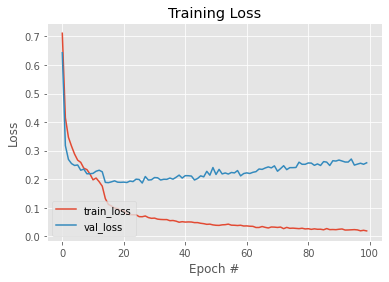

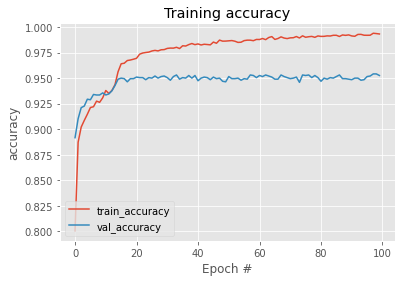

61/61 [==============================] - 1s 12ms/step - loss: 0.3120 - classified_loss: 0.2845 - contrastive_loss: 2.7520 - classified_accuracy: 0.9334 - contrastive_accuracy: 0.0000e+00
test acc  :  0.9334365129470825
test loss :  0.3119957149028778
f1 score  :  0.9284868775077304
[[183   3   4   0   0   0   0   0   0   1   1   0]
 [  3 174   3   0   0   0   1   0   0   1   3   0]
 [  0   3 181   1   0   0   0   0   0   1   3   1]
 [  2   0   1 223   1   0   2   4   4   0   1   0]
 [  0   0   0   0  94   0   1   0   1   1   1   0]
 [  0   0   0   0   0 160   0   0   0   0   4   0]
 [  0   0   0   0   0   0 187   0   0   0   1   0]
 [  1   2   2   1   1   0   0 103   3   1   1   1]
 [  2   2   5   1   1   1   0   5  84   1   3   0]
 [  0   0   3   1   0   2   1   3   0 153  12   0]
 [  0   2   8   0   0   0   0   0   0   3 225   0]
 [  0   1   0   1   0   1   0   0   1   1   2  42]]


<Figure size 432x288 with 0 Axes>

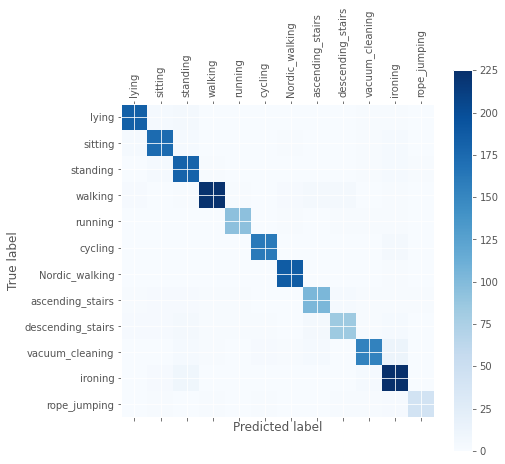

In [27]:
from utils import *

print("Random State : ", time_string)
plot_training_loss_balancing(history, None)
plot_training_acc_balancing(history, None)
plt.clf()
print_test_result_balancing(model, filepath, x_test, y_test, y_test, dataset=dataset_name)

In [ ]:
# encoder 뒤에 dropout 추가하기 >> 효과가 좋다

# epoch 조절하기(지금은 너무 많다)
# l2 regularization 생각해보기
# Siamese Network 생각해보기 >> 두 개의 input에서, none-augmented가 classifier로 갈지 augmented가 classifier로 갈지도 확인해보기(베스트는 none이 classifier로 가는 것)
# Contrastive features가 얼마나 영향을 주는지

# time_warp 뿐만 아니라 다양한 augmentation 확인해보기